In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser

af.set_backend(params.backend)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [29]:
N_LGL = 8
xi_LGL  = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))
eta_LGL = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))

_, L_p = lagrange.lagrange_polynomials(xi_LGL)
_, L_q = lagrange.lagrange_polynomials(eta_LGL)

L_p = af.np_to_af_array(L_p)
L_q = af.np_to_af_array(L_q)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [3]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 49 nodes.
gmshTranslator: Mesh has 25 elements.
gmshTranslator: Processed 78 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


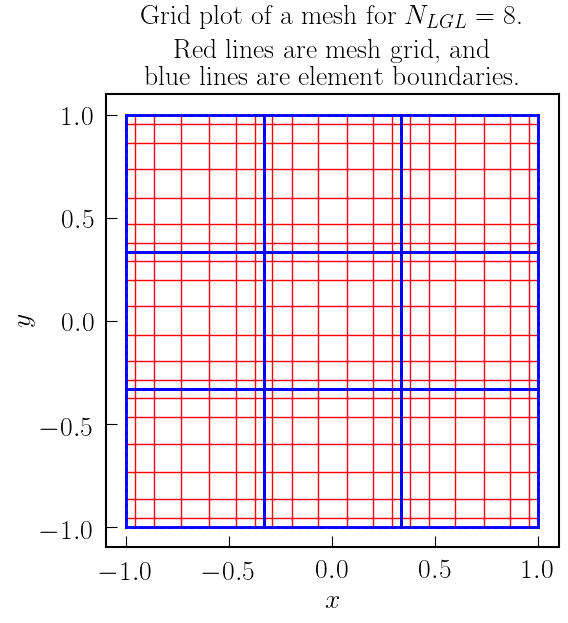

In [16]:
axes_handler = plt.axes()

msh_parser.plot_mesh_grid(nodes, elements, np.array(xi_LGL), np.array(eta_LGL), axes_handler)

plt.title(r'Grid plot of a mesh for $N_{LGL} = 8$.'
          '\n Red lines are mesh grid, and \n'
          'blue lines are element boundaries.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.show()

In [24]:
eta = af.tile(eta_LGL, N_LGL)
xi = af.flat(af.transpose(af.tile(xi_LGL, 1, N_LGL)))

dxi_dx  = 1 / w2d.dx_dxi(nodes[elements[0]][:, 0], xi, eta)
dxi_dy  = 1 / w2d.dy_dxi(nodes[elements[0]][:, 1], xi, eta)
deta_dx = 1 / w2d.dx_deta(nodes[elements[0]][:, 0], xi, eta)
deta_dy = 1 / w2d.dy_deta(nodes[elements[0]][:, 1], xi, eta)

In [26]:
def F_xi(u):
    '''
    '''
    dxi_dx  = 1 / w2d.dx_dxi(nodes[elements[0]][:, 0], xi, eta)
    dxi_dy  = 1 / w2d.dy_dxi(nodes[elements[0]][:, 1], xi, eta)
    
    return w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

def F_eta(u):
    '''
    '''
    deta_dx = 1 / w2d.dx_deta(nodes[elements[0]][:, 0], xi, eta)
    deta_dy = 1 / w2d.dy_deta(nodes[elements[0]][:, 1], xi, eta)    
    
    return w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy

In [32]:
dLp_dxi  = utils.polynomial_derivative(L_p)
dLq_deta = utils.polynomial_derivative(L_q)

In [ ]:
nodes
elements


In [ ]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (dx_dxi(x_nodes, xi, eta))**2 \
             + (dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (dx_deta(x_nodes, xi, eta))**2 \
             + (dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (dx_dxi(x_nodes, xi, eta))  \
            * (dx_deta(x_nodes, xi, eta)) \
            + (dy_dxi(y_nodes, xi, eta))  \
            * (dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return np.array(ans)


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = np.array([[d, -b],
                    [-c, a]])
    
    return np.array(ans)/det


def sqrtgDet(x_nodes, y_nodes, xi, eta):
    '''
    '''
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    return (a*d - b*c)**0.5
